<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC 3: Métodos supervisados

En esta práctica veremos diferentes métodos supervisados y trataremos de optimizar diferentes métricas. Veremos como los diferentes modelos clasifican los puntos y con cuales obtenemos mayor precisión. Después aplicaremos todo lo que hemos aprendido hasta ahora a un dataset nuevo simulando un caso práctico real.

1. [Exploración de algoritmos supervisados](#eje1) \
    1.0. Carga de datos \
    1.1. Naive-Bayes\
    1.2. Análisis Discriminante Lineal (LDA) y Análisis Discriminante Cuadrtático (QDA)\
    1.3. K vecinos más próximos (KNN)\
    1.4. Máquinas de soporte vectorial (SVM)\
    1.5. Árboles de decisión
2. [Implementación del caso práctico](#ej2)\
    2.0. Carga de datos\
    2.1. Análisis descriptivo\
    2.2. Entrenamiento, validación y prueba de una red neuronal con los datos originales\
    2.3. Submuestreo\
    2.4. Sobremuestreo\
    2.5. Generación de datos sintéticos\
    2.6. Sintonizando los modelos (BONUS)

<u>Consideraciones generales</u>: 

- La solución planteada no puede utilizar métodos, funciones o parámetros declarados **_deprecated_** en futuras versiones, a excepción de la carga de datos cómo se indica posteriormente.
- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
    <strong>Nombre y apellidos: EDUARDO MORA GONZÁLEZ</strong>
</div>

In [43]:
import numpy as np 
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

<a id='ej1'></a>
# 1. Exploración de algoritmos supervisados

## 1.0. Carga de datos

El conjunto de datos Spiral es un conjunto de datos sintéticos que se utiliza comúnmente en el aprendizaje automático y la minería de datos como un problema de clasificación no lineal. El conjunto de datos consta de dos espirales entrelazadas que se asemejan a las espirales de Arquímedes. Cada espiral se compone de un conjunto de puntos distribuidos uniformemente en el plano, y los puntos de cada espiral están etiquetados con una clase diferente.

El objetivo es utilizar un algoritmo de clasificación para predecir la clase de un punto desconocido en función de sus coordenadas (x, y). Debido a la naturaleza entrelazada de las espirales, este problema de clasificación es no lineal y, por lo tanto, es un desafío interesante para los algoritmos de aprendizaje automático.

El siguiente código cargará 2000 puntos en la variable `X` y la correspondientes etiqueta o grupo (en forma numérica) en la variable `y`. Podemos comprobar que la carga ha sido correcta obteniendo las dimensiones de estas dos variables y el gráfico de los puntos (con colores diferentes para cada grupo).

Dimensiones de X (2000, 2)
Dimensiones de y (2000,)


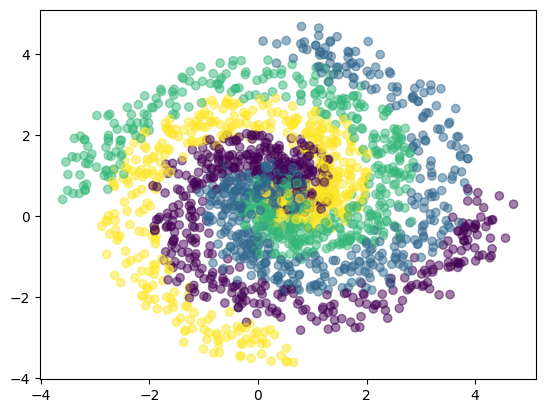

In [81]:
#data = pd.read_pickle('spiral.pickle')
data = pd.read_pickle('/kaggle/input/datospec3/spiral.pickle')

# Convertir las dos primeras columnas en un array de numpy
X = data[['X1', 'X2']].values

# Convertir la última columna en un array de numpy
y = data['y'].values

print('Dimensiones de X', X.shape)
print('Dimensiones de y', y.shape)

# Hacer la representación gráfica
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.viridis, alpha=0.5)
plt.show()

A lo largo de los ejercicios aprenderemos a ver gráficamente las fronteras de decisión que nos devuelven los diferentes modelos. Para ello utilizaremos la función definida a continuación, que sigue los siguientes pasos:

   - Crear una [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) con los valores mínimo y máximo de 'x' e 'y'.
   - Predecir el clasificador con los valores de la _meshgrid_.
   - Hacer un _reshape_ de los datos para tener el formato correspondiente.
  
Una vez hecho esto, ya podemos hacer el gráfico de las fronteras de decisión y añadir los puntos reales. Así veremos las áreas que el modelo considera que son de una clase y las que considera que son de otra. Al poner encima los puntos veremos si los clasifica correctamente en el área que les corresponde.

In [83]:
def plot_decision_boundary(clf, X, Y, cmap='Paired'):
    if not isinstance(X, np.ndarray):  # Si X no es un array de numpy, lo convierte
        X = X.to_numpy()
    
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7,7))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=cmap, edgecolors='k', label=Y);

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> 

Dividid el _dataset_ en dos subconjuntos, __*train*__ (80% de los datos) y __*test*__ (20% de los datos). Nombrad los conjuntos como: X_train, X_test, y_train, y_test. Utilizad la opción `random_state = 24`.
    
Podéis utilizar la implementación `train_test_split` de `sklearn`.
    
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [84]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

print("Tamaño de X_train:", X_train.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Tamaño de y_test:", y_test.shape)

Tamaño de X_train: (1600, 2)
Tamaño de y_train: (1600,)
Tamaño de X_test: (400, 2)
Tamaño de y_test: (400,)


### 1.1. Gaussian Naïve Bayes

El objetivo de este primer ejercicio es entender el funcionamiento del algoritmo Naïve-Bayes, un algoritmo peculiar ya que se basa en el teorema de Bayes para calcular la probabilidad de que una observación pertenezca a cada una de las clases. El modelo asume que las características de entrada son independientes entre sí, lo que permite simplificar el cálculo de las probabilidades condicionales.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

- Con el dataset de _train_, entrenad un modelo de Naïve-Bayes. Podéis utilizar el clasificador `GaussianNB` de `sklearn`.

- Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_.

- Calculad la matriz de confusión sobre _test_.
    
- Representad gráficamente la frontera de decisión con el de _test_.
    
Podéis utilizar la función `plot_decision_boundary` creada previamente, y las funciones `accuracy_score` y `confusion_matrix` del paquet `metrics` de `sklearn`.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

Exactitud en entrenamiento: 0.294375
Exactitud en test: 0.2475
Matriz de confusión en test:
[[15 27 27 33]
 [32 37 10 31]
 [32 35 23  9]
 [18 23 24 24]]


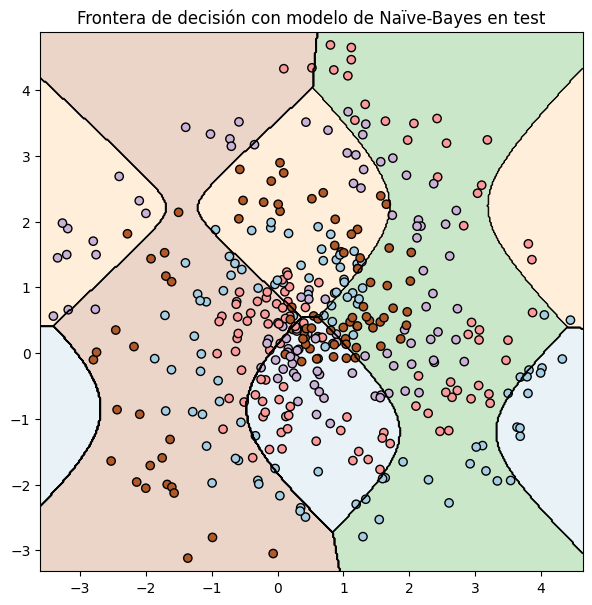

In [47]:
# Entrenar modelo de Naïve-Bayes
clf = GaussianNB()
clf.fit(X_train, y_train)

# Hacer predicciones y calcular exactitud en conjuntos de entrenamiento y test
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("Exactitud en entrenamiento:", train_acc)
print("Exactitud en test:", test_acc)

# Calcular matriz de confusión en conjunto de test
conf_mat = confusion_matrix(y_test, y_test_pred)
print("Matriz de confusión en test:")
print(conf_mat)

# Representar gráficamente la frontera de decisión en conjunto de test
plot_decision_boundary(clf, X_test, y_test)
plt.title("Frontera de decisión con modelo de Naïve-Bayes en test")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 
    
Observando la frontera de decisión, se puede ver que las regiones para cada clase no son muy definidas y se superponen entre ellas. Esto puede ser debido a la suposición de independencia entre las variables que hace el algoritmo Naïve-Bayes, lo que puede llevar a una falta de precisión en la delimitación de las regiones de decisión.

En cuanto a las predicciones obtenidas sobre el conjunto de test, la exactitud obtenida es relativamente baja, lo que sugiere que el modelo no está generalizando bien para datos nuevos. La matriz de confusión muestra que hay una cantidad significativa de falsos positivos y falsos negativos en todas las clases, lo que indica que el modelo está teniendo dificultades para distinguir entre ellas.

</div>

### 1.2 Análisis Discriminante Lineal (LDA) y Análisis Discriminante Cuadrtático (QDA)

Ahora analizaremos dos algoritmos que se basan en la transformación lineal de las características de entrada para maximizar la separación entre las clases. Estos modelos suponen que las características tienen una distribución gaussiana y así poder calcular las probabilidades condicionales de cada clase y asignar la clase con la mayor probabilidad como la clase predicha para una observación dada. 

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

- Con el dataset de _train_, entrenad un modelo de Análisis Discriminate Lineal (LDA). Podéis utilizar el clasificador `LinearDiscriminantAnalysis` de `sklearn`.

- Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_.

- Calculad la matriz de confusión sobre _test_.
    
- Representad gráficamente la frontera de decisión con el de _test_.

</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

Exactitud en entrenamiento: 0.255
Exactitud en test: 0.2475
Matriz de confusión en test:
 [[24 29 24 25]
 [27 27 21 35]
 [27 28 24 20]
 [17 25 23 24]]


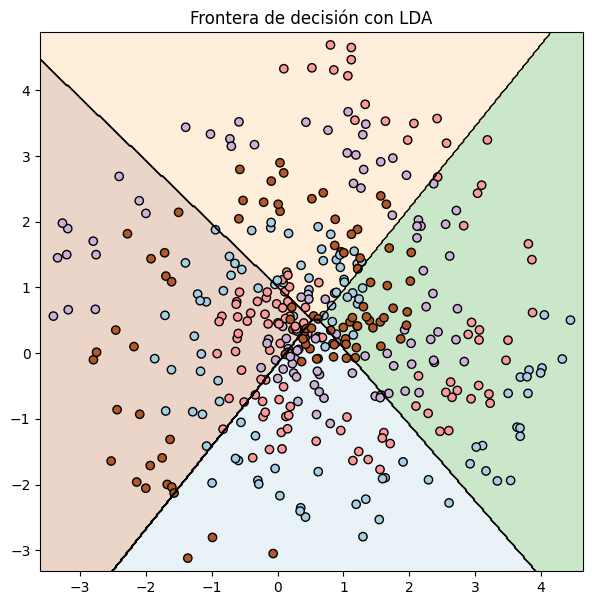

In [48]:
# Entrenar modelo
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Accuracy en train
acc_train = lda.score(X_train, y_train)
print("Exactitud en entrenamiento:", acc_train)

# Accuracy en test
acc_test = lda.score(X_test, y_test)
print("Exactitud en test:", acc_test)

# Matriz de confusión en test
from sklearn.metrics import confusion_matrix

y_pred_test = lda.predict(X_test)
confusion_mtx = confusion_matrix(y_test, y_pred_test)
print("Matriz de confusión en test:\n", confusion_mtx)

# Representación gráfica de la frontera de decisión
plot_decision_boundary(lda, X_test, y_test)
plt.title("Frontera de decisión con LDA")
plt.show()


<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 

Las fronteras de decisión en el modelo LDA son lineales, ya que este algoritmo asume que las características tienen una distribución normal y que las matrices de covarianza son iguales entre las clases. Por lo tanto, el modelo busca una línea recta que separe las clases y maximice la distancia entre las medias de cada clase proyectada en esa línea.

En cuanto a las predicciones obtenidas en el conjunto de test, podemos observar una precisión es igual que la precisión obtenida en el modelo Naïve Bayes. La matriz de confusión muestra que el modelo tiene dificultades para clasificar las diferentes clases, ya que se observan valores similares en las cuatro clases.

</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

- Con el dataset de _train_, entrenad un modelo de Análisis Discriminate Cuadrático (QDA). Podéis utilizar el clasificador `QuadraticDiscriminantAnalysis` de `sklearn`.

- Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_.

- Calculad la matriz de confusión sobre _test_.
    
- Representad gráficamente la frontera de decisión con el de _test_.

</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

Exactitud en entrenamiento: 0.264
Exactitud en test: 0.215
Matriz de confusión en test:
[[28 13 33 28]
 [40 18 11 41]
 [38 36 19  6]
 [16 29 23 21]]


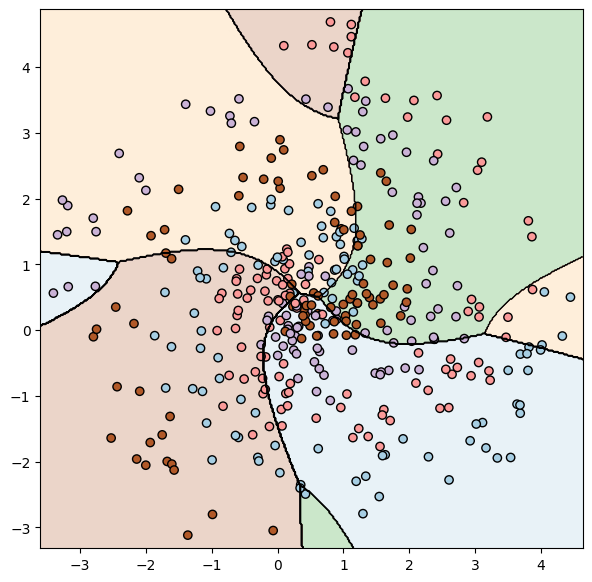

In [49]:
# Entrenar modelo de QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

# Calcular accuracy en train y test
acc_train_qda = qda.score(X_train, y_train)
acc_test_qda = qda.score(X_test, y_test)

print("Exactitud en entrenamiento: {:.3f}".format(acc_train_qda))
print("Exactitud en test: {:.3f}".format(acc_test_qda))

# Calcular matriz de confusión en test
from sklearn.metrics import confusion_matrix
y_pred_qda = qda.predict(X_test)
cm_qda = confusion_matrix(y_test, y_pred_qda)
print("Matriz de confusión en test:")
print(cm_qda)

# Representar frontera de decisión en test
plot_decision_boundary(qda, X_test, y_test)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
   - ¿En que se diferencian el algoritmo LDA del QDA?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 


Las fronteras de decisión obtenidas con el algoritmo QDA son más complejas y no se limitan a una frontera lineal como en el caso del LDA. Esto tiene sentido ya que el QDA permite una mayor flexibilidad en la forma de la frontera de decisión al permitir diferentes matrices de covarianza para cada clase.

Las predicciones obtenidas sobre el conjunto de test son menos precisas en comparación con los otros dos algoritmos.

El LDA y el QDA difieren en cómo modelan las covarianzas de las diferentes clases. El LDA asume que todas las clases tienen la misma matriz de covarianza, mientras que el QDA permite que cada clase tenga su propia matriz de covarianza. En consecuencia, el QDA puede capturar patrones más complejos y, por lo tanto, puede ser más preciso que el LDA si las covarianzas de las diferentes clases son diferentes. Sin embargo, si las covarianzas son iguales o muy similares entre las clases, el LDA puede ser más preciso ya que tiene una mayor capacidad de generalización.

</div>

### 1.3. K- vecinos más próximos KNN

En este punto entenderemos el funcionamiento del algoritmo KNN (que se basa en la proximidad de los puntos de datos en un espacio de características), intuir sus principales ventajas o desventajas y entender la influencia de los parámetros de los que está compuesto.

K-Nearest-Neighbor es un algoritmo basado en instancia de tipo supervisado. 

Vamos a ver qué significa esto:

  - Supervisado: tenemos etiquetado nuestro conjunto de datos de entrenamiento, con la clase o resultado esperado.
  - Basado en instancia (_Lazy Learning_): Esto significa que nuestro algoritmo no aprende explícitamente un modelo (como por ejemplo en Regresión Logística o árboles de decisión), sino que memoriza las instancias de entrenamiento que son utilizadas como "conocimiento" para la fase de predicción.

¿Cómo funciona KNN?

  - Calculamos la distancia entre el ítem a clasificar y los demás ítems del dataset de entrenamiento.
  - Seleccionamos los "k" elementos más cercanos, es decir, con menor distancia, según la distancia que utilizamos (euclídea, coseno, manhattan, etc).
  - Por último realizamos una "votación de mayoría" entre los k puntos: los de la clase que "dominan" decidirán su clasificación final.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Con el dataset de _train_, entrenad un clasificador KNN con hiperparámetro `n_neighbors=2`. Podéis utilizar el clasificador `KNeighborsClassifier` de `sklearn`.

- Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_.

- Calculad la matriz de confusión sobre _test_.
    
- Representad gráficamente la frontera de decisión con el de _test_.


Si al entrenar el clasificador sale un warning y lo quieres ignorar, ejecuta el siguiente código antes del entrenamiento:

`import warnings`\
`warnings.filterwarnings('ignore', message='^.*will change.*$', category=FutureWarning)`

</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [50]:
import warnings
warnings.filterwarnings('ignore', message='^.*will change.*$', category=FutureWarning)

Exactitud en entrenamiento: 0.883125
Exactitud en test: 0.775
Matriz de confusión en test:
 [[88  6  1  7]
 [11 93  5  1]
 [ 5 15 77  2]
 [14  5 18 52]]


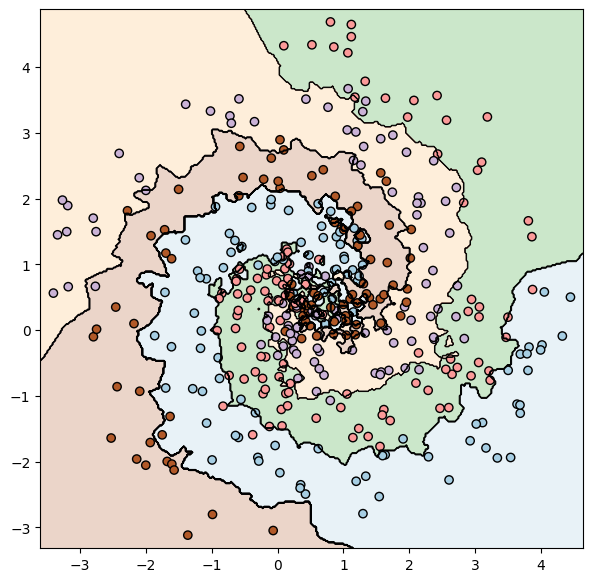

In [51]:
# Crear el clasificador KNN
knn = KNeighborsClassifier(n_neighbors=2)

# Entrenar el modelo con el dataset de entrenamiento
knn.fit(X_train, y_train)

# Evaluar la exactitud del modelo en el dataset de entrenamiento
train_accuracy = knn.score(X_train, y_train)
print("Exactitud en entrenamiento:", train_accuracy)

# Evaluar la exactitud del modelo en el dataset de test
test_accuracy = knn.score(X_test, y_test)
print("Exactitud en test:", test_accuracy)

# Obtener la matriz de confusión en el dataset de test
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión en test:\n", cm)

# Representar gráficamente la frontera de decisión con el dataset de test
plot_decision_boundary(knn, X_test, y_test)

En el modelo entrenado, hemos fijado el parámetro `n_neighbors` de forma arbitraria. Pero podría ser que con otro valor obtuviéramos una mejor predicción.

Para conocer el valor óptimo de los parámetros de un modelo (_hyperparameter tunning_) se suele utilizar una búsqueda de rejilla (_grid search_). Es decir, entrenar un modelo para cada combinación de hiperparámetros posible y evaluarlo utilizando validación cruzada (_cross validation_) con 5 particiones estratificadas. Posteriormente, se elige la combinación de hiperparàmetres que mejores resultados haya obtenido.

En este caso sólo queremos optimizar un hiperparámetro:

   - 𝑘: el número de vecinos que se consideran para clasificar un nuevo ejemplo. Probaremos con todos los valores entre 1 y 20.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Cálculo del valor óptimo del hiperparámetro _k_ (`n_neighbors`). Utilizad una búsqueda de rejilla con validación cruzada para encontrar el valor óptimo de _k_. Por cada valor, calculad su promedio y la desviación estándar. Implementad un _heatmap_ para visualizar la precisión según los diferentes valores del hiperparámetro.
    
Puede utilizar el módulo `GridSearchCV` de `sklearn` el cálculo del mejor hiperparámetro, y `heatmap` de `Seaborn`.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

Mejor valor de k: 15
Precisión media: 0.80
Desviación estándar: 0.01


/tmp/ipykernel_34/3771300056.py:21: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  grid_results = grid_results.pivot(index="param_n_neighbors", columns="mean_test_score", values="std_test_score")


<AxesSubplot: xlabel='mean_test_score', ylabel='param_n_neighbors'>

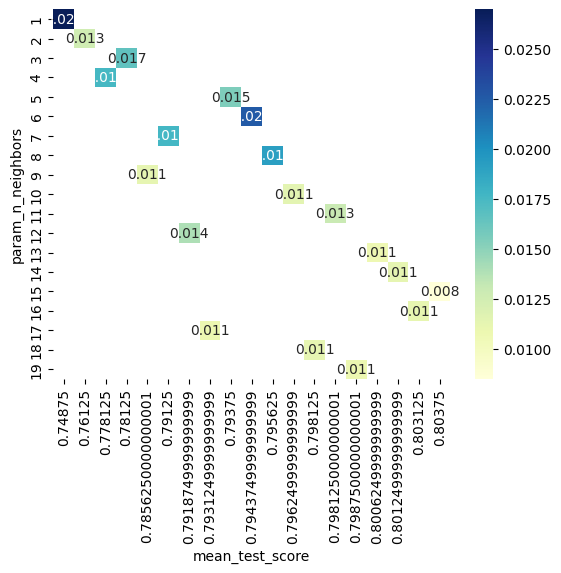

In [52]:
# definir los valores de k que queremos probar
k_values = list(range(1, 20))

# crear el diccionario de parámetros para GridSearchCV
param_grid = {'n_neighbors': k_values}

# crear el objeto GridSearchCV con el clasificador KNN
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# imprimir los resultados
print("Mejor valor de k: {}".format(grid_search.best_params_['n_neighbors']))
print("Precisión media: {:.2f}".format(grid_search.cv_results_['mean_test_score'][grid_search.best_index_]))
print("Desviación estándar: {:.2f}".format(grid_search.cv_results_['std_test_score'][grid_search.best_index_]))

# crear heatmap de la precisión según los diferentes valores de k
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results = grid_results.pivot(index="param_n_neighbors", columns="mean_test_score", values="std_test_score")
sns.heatmap(grid_results, cmap="YlGnBu", annot=True, fmt=".3f")

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Con el dataset de _train_, entrenad un clasificador KNN con el mejor hiperparámetro encontrado. 

- Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_.

- Calculad la matriz de confusión sobre _test_.
    
- Representad gráficamente la frontera de decisión con el de _test_.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

Exactitud en entrenamiento: 0.831
Exactitud en test: 0.790
Matriz de confusión en test:
 [[75  9  2 16]
 [ 8 93  9  0]
 [ 5  7 82  5]
 [10  3 10 66]]


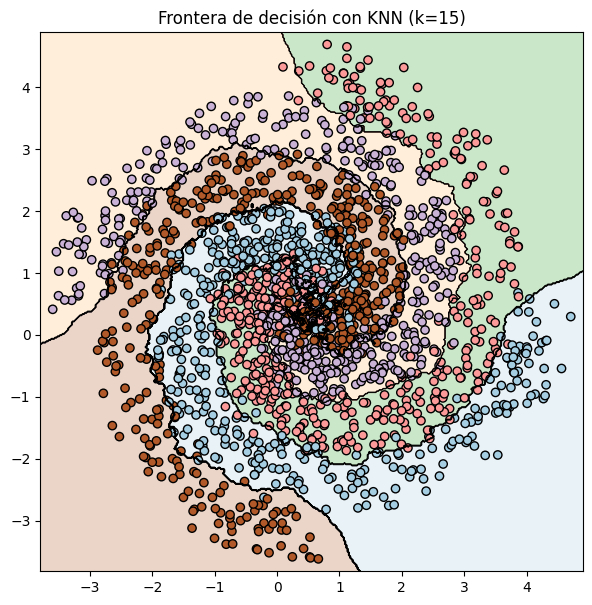

In [53]:
# Entrenamiento del modelo con el mejor valor de k
k = 15
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Evaluación del modelo en train y test
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print("Exactitud en entrenamiento: {:.3f}".format(train_acc))
print("Exactitud en test: {:.3f}".format(test_acc))

# Matriz de confusión en test
cm = confusion_matrix(y_test, y_test_pred)
print("Matriz de confusión en test:\n", cm)

# Frontera de decisión con test
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_boundary(knn, X_combined, y_combined)
plt.title("Frontera de decisión con KNN (k=15)")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

   - Comentar los resultados de la búsqueda del mejor hiperparámetro.
   - ¿Cómo se visualiza gráficamente el cambio del valor `n_neighbors`? ¿Tiene sentido esta diferencia entre los dos gráficos al cambiar el parámetro?
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 

La búsqueda del mejor hiperparámetro ha permitido encontrar que el valor óptimo de n_neighbors es 15, con una precisión media de 0.80 y una desviación estándar de 0.01. Esto significa que un valor de k=15 sería el más adecuado para este problema.

La visualización gráfica del cambio del valor de n_neighbors se realiza mediante un heatmap, donde se muestra cómo cambia la precisión media para diferentes valores de k y diferentes folds en el proceso de validación cruzada. Se puede observar que la precisión media alcanza un máximo alrededor de k=15 y disminuye gradualmente para valores mayores de k.

Es interesante observar que, aunque la precisión media alcanza un máximo alrededor de k=15, la desviación estándar se mantiene bastante constante en todo el rango de valores de k. Esto indica que el modelo es bastante estable en su capacidad de generalización, y que la elección del valor de k no tendría un gran impacto en la varianza del modelo.

En cuanto a las fronteras de decisión, al tratarse de un modelo basado en la distancia entre puntos, se espera que la frontera de decisión sea suave y no lineal. Esto se puede observar en la representación gráfica de la frontera de decisión para el clasificador KNN con k=15, donde se muestra una frontera con curvas suaves que separan las regiones de las diferentes clases.

En cuanto a las predicciones obtenidas sobre el conjunto de test, se observa una precisión de 0.79, lo que indica que el modelo tiene una buena capacidad de generalización. Además, la matriz de confusión muestra que el modelo es capaz de clasificar bien las observaciones de todas las clases, aunque hay algunas confusiones entre algunas clases.

</div>

### 1.4. Máquinas de soporte vectorial SVM

Las Support Vector Machine (SVM) se fundamentan en el _Maximal Margin Classifier_, que a su vez, se basan en el concepto de hiperplano.

En un espacio p-dimensional, un hiperplano se define como un subespacio plano y afín de dimensiones p-1. El término afín significa que el subespacio no debe pasar por el origen. En un espacio de dos dimensiones, el hiperplano es un subespacio de 1 dimensión, es decir, una recta. En un espacio tridimensional, un hiperplano es un subespacio de dos dimensiones, un plano convencional. Para dimensiones p>3 no es intuitivo visualizar un hiperplano, pero el concepto de subespacio con p-1 dimensiones se mantiene.

La definición de hiperplano para casos perfectamente separables linealmente resulta en un número infinito de posibles hiperplanos, lo que hace necesario un método que permita seleccionar uno de ellos como clasificador óptimo.

La solución a este problema consiste en seleccionar como clasificador óptimo al que se conoce como _maximal margin hyperplane_ o hiperplano óptimo de separación, que se corresponde con el hiperplano que se encuentra más alejado de todas las observaciones de entrenamiento. Para obtenerlo, se debe calcular la distancia perpendicular de cada observación a un determinado hiperplano. La menor de estas distancias (conocida como margen) determina cómo de lejos está el hiperplano de las observaciones de entrenamiento. El _maximal margin hyperplane_ se define como el hiperplano que consigue un mayor margen, es decir, que la distancia mínima entre el hiperplano y las observaciones es lo más grande posible. Aunque esta idea suena razonable, no es posible aplicarla, ya que habría infinitos hiperplanos contra los que medir las distancias. En su lugar, se recurre a métodos de optimización.

El proceso de optimización tiene la peculiaridad de que sólo las observaciones que se encuentran justo al margen o que lo violan influyen sobre el hiperplano. A estas observaciones se les conoce como vectores soporte (_vectors suport_) y son las que definen el clasificador obtenido.

#### Los _kernels_ en SVM

Hay veces en que no hay manera de encontrar un hiperplano que permita separar dos clases. En estos casos decimos que las clases no son linealmente separables. Para resolver este problema podemos utilizar el truco del núcleo .

El truco del núcleo (_kernel trick_) consiste en utilizar una dimensión nueva en la que podamos encontrar un hiperplano para separar las clases. Se puede ver un un ejemplo en: https://www.youtube.com/watch?v=OdlNM96sHio

Al igual que en el algoritmo visto anteriormente (KNN), las SVM también dependen de varios hiperparámetros. 

En este caso intentaremos optimizar dos hiperparámetros:

  - **C**: es la regularización, es decir, el valor de penalización de los errores en la clasificación. Indica el compromiso entre obtener el hiperplano con el margen más grande posible y clasificar el máximo número de ejemplos correctamente. Probaremos los valores: 0.01, 0.1, 1, 10, 50, 100 y 200.
  
  - **Gama**: coeficiente que multiplica la distancia entre dos puntos en el kernel radial. Para decirlo a "grosso modo", cuanto más pequeño es gama, más influencia tienen dos puntos cercanos. Probaremos los valores: 0.001, 0.01, 0.1, 1 y 10.
  
Al igual que en el caso anterior, para validar el rendimiento del algoritmo con cada combinación de hiperparámetros utilizaremos validación cruzada (_cross-validation_) con 4 particiones estratificadas.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> 

Cálcular del valor óptimo de los hiperparámetros _C_ y _gama_. Utilizad una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcular su promedio y la desviación estándar. Haced un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.

Podéis utilizar el módulo `GridSearchCV` de `sklearn` el cálculo de los mejores hiperparámetros con el clasificador SVC (de `SVM` de `sklearn`), y `heatmap` de `Seaborn`.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [54]:
# Definir los valores de los hiperparámetros que queremos probar
param_grid = {'C': [0.01, 0.1, 1, 10, 50, 100, 200], 
              'gamma': [0.001, 0.01, 0.1, 1, 10]}

# Crear una instancia del clasificador SVC y del GridSearchCV
svc = SVC(kernel='rbf')
grid_search = GridSearchCV(svc, param_grid, cv=4)

# Ajustamos el GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Acceder al valor óptimo de los hiperparámetros con el atributo best_params_ y la precisión media correspondiente con el atributo best_score_
print("Mejor valor de C:", grid_search.best_params_['C'])
print("Mejor valor de gamma:", grid_search.best_params_['gamma'])
print("Precisión media con validación cruzada:", grid_search.best_score_)

# Obtenemos los resultados y los mostramos
results = grid_search.cv_results_
for mean_score, std_score, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
    print("Precisión media:", round(mean_score, 3), "±", round(std_score, 3), "para", params)



Mejor valor de C: 50
Mejor valor de gamma: 1
Precisión media con validación cruzada: 0.818125
Precisión media: 0.257 ± 0.001 para {'C': 0.01, 'gamma': 0.001}
Precisión media: 0.257 ± 0.001 para {'C': 0.01, 'gamma': 0.01}
Precisión media: 0.257 ± 0.001 para {'C': 0.01, 'gamma': 0.1}
Precisión media: 0.258 ± 0.001 para {'C': 0.01, 'gamma': 1}
Precisión media: 0.257 ± 0.001 para {'C': 0.01, 'gamma': 10}
Precisión media: 0.257 ± 0.001 para {'C': 0.1, 'gamma': 0.001}
Precisión media: 0.246 ± 0.015 para {'C': 0.1, 'gamma': 0.01}
Precisión media: 0.54 ± 0.028 para {'C': 0.1, 'gamma': 0.1}
Precisión media: 0.806 ± 0.006 para {'C': 0.1, 'gamma': 1}
Precisión media: 0.803 ± 0.013 para {'C': 0.1, 'gamma': 10}
Precisión media: 0.241 ± 0.02 para {'C': 1, 'gamma': 0.001}
Precisión media: 0.274 ± 0.016 para {'C': 1, 'gamma': 0.01}
Precisión media: 0.764 ± 0.007 para {'C': 1, 'gamma': 0.1}
Precisión media: 0.811 ± 0.014 para {'C': 1, 'gamma': 1}
Precisión media: 0.803 ± 0.014 para {'C': 1, 'gamma': 10

<AxesSubplot: >

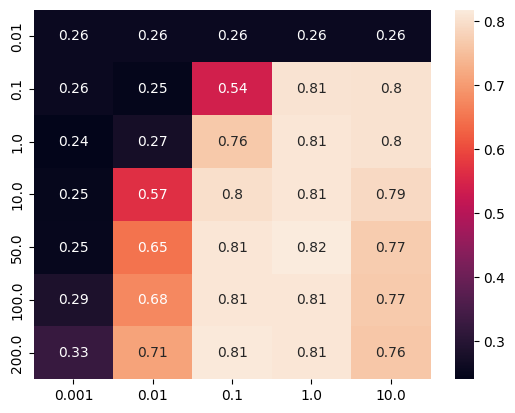

In [55]:
# Heatmap
scores = np.array(results['mean_test_score']).reshape(len(param_grid['C']), len(param_grid['gamma']))
df = pd.DataFrame(scores, index=param_grid['C'], columns=param_grid['gamma'])
sns.heatmap(df, annot=True)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Con el dataset de _train_, entrenad un modelo de SVM con la mejor combinación de parámetros encontrada. 

- Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_.

- Calculad la matriz de confusión sobre _test_.
    
- Representad gráficamente la frontera de decisión con el de _test_.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

Accuracy en train: 0.853
Accuracy en test: 0.770
Matriz de confusión:
[[74 10  1 17]
 [ 8 89 12  1]
 [ 4  7 82  6]
 [ 6  2 18 63]]


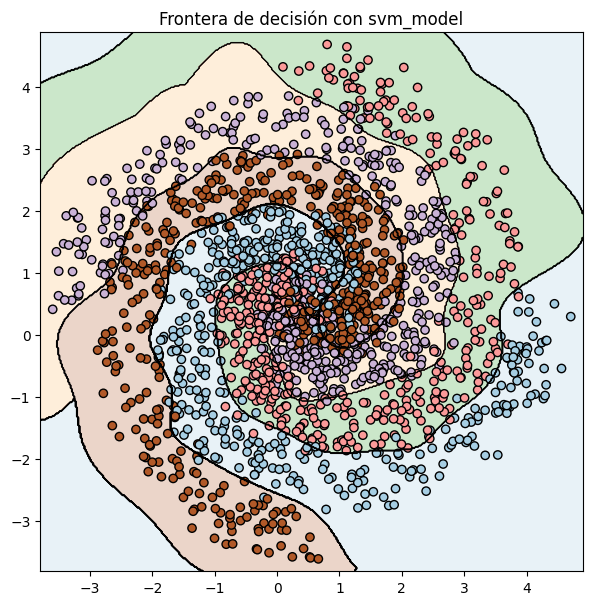

In [56]:
# Entrenar modelo con la mejor combinación de hiperparámetros
svm_model = SVC(C=50, gamma=1)
svm_model.fit(X_train, y_train)

# Calcular accuracy en train y test
train_acc = accuracy_score(y_train, svm_model.predict(X_train))
test_acc = accuracy_score(y_test, svm_model.predict(X_test))
print(f"Accuracy en train: {train_acc:.3f}")
print(f"Accuracy en test: {test_acc:.3f}")

# Calcular matriz de confusión en test
conf_mat = confusion_matrix(y_test, svm_model.predict(X_test))
print("Matriz de confusión:")
print(conf_mat)

# Frontera de decisión con test
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_boundary(svm_model, X_combined, y_combined)
plt.title("Frontera de decisión con svm_model")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

   - Comentar los resultados de la búsqueda de los mejores hiperparámetros.
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 

La búsqueda de los mejores hiperparámetros ha dado como resultado un modelo con un accuracy en train del 85,3% y un accuracy en test del 77,0%. Estos valores indican que el modelo está generalizando razonablemente bien, aunque podría estar sufriendo cierto overfitting.

Las fronteras de decisión son bastante complejas, con múltiples curvas y separaciones no lineales. Esto es esperable con el algoritmo SVM, ya que es capaz de construir fronteras de decisión no lineales mediante la utilización de kernels.

En cuanto a las predicciones obtenidas sobre el conjunto de test, vemos que el modelo es capaz de clasificar correctamente el 77% de las observaciones.

</div>

### 1.5. Árboles de decisión

Los árboles de decisión son modelos predictivos formados por reglas binarias (si / no) con las que se consigue repartir las observaciones en función de sus atributos y predecir así el valor de la variable respuesta.

Los árboles pueden ser **clasificadores** (para clasificar clases, tales como nuestro ejemplo), o bien **regresores** (para predecir variables continuas).

#### Construcción de un árbol

La creación de las ramificaciones de los árboles se logra mediante el algoritmo de *recursive binary splitting*. Este algoritmo consta de tres pasos principales:

   - El proceso se inicia en lo alto del árbol, donde todas las observaciones pertenecen a la misma región.
   - Se identifican todos los posibles puntos de corte para cada uno de los predictores. Los puntos de corte son cada uno de sus niveles.
   - se evalúan las posibles divisiones de cada predictor de acuerdo a una determinada medida. En el caso de los clasificadores se utilizan: *classification error rate*, Gini, entropía, chi-square.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Con el dataset de _train_, entrenad un arbol de desición. Podéis utilizar el clasificador `DecisionTreeClassifier` (de `tree` de `sklearn`).

- Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_.

- Calculad la matriz de confusión sobre _test_.
    
- Representad gráficamente la frontera de decisión con el de _test_. 
    
- Representad el árbol. Podéis utilizar el comando `plot.tree` de la biblioteca `tree` de `sklearn`.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

Accuracy en train: 1.0
Accuracy en test: 0.725
Matriz de confusión:
[[72 16  1 13]
 [ 9 84 14  3]
 [ 5 13 72  9]
 [12  2 13 62]]


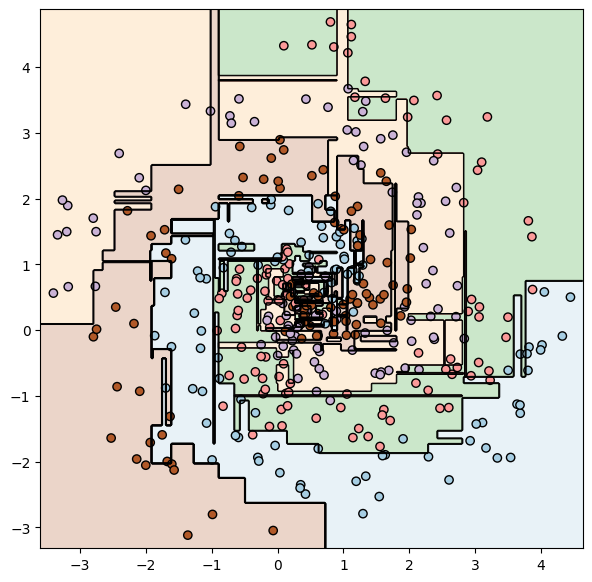

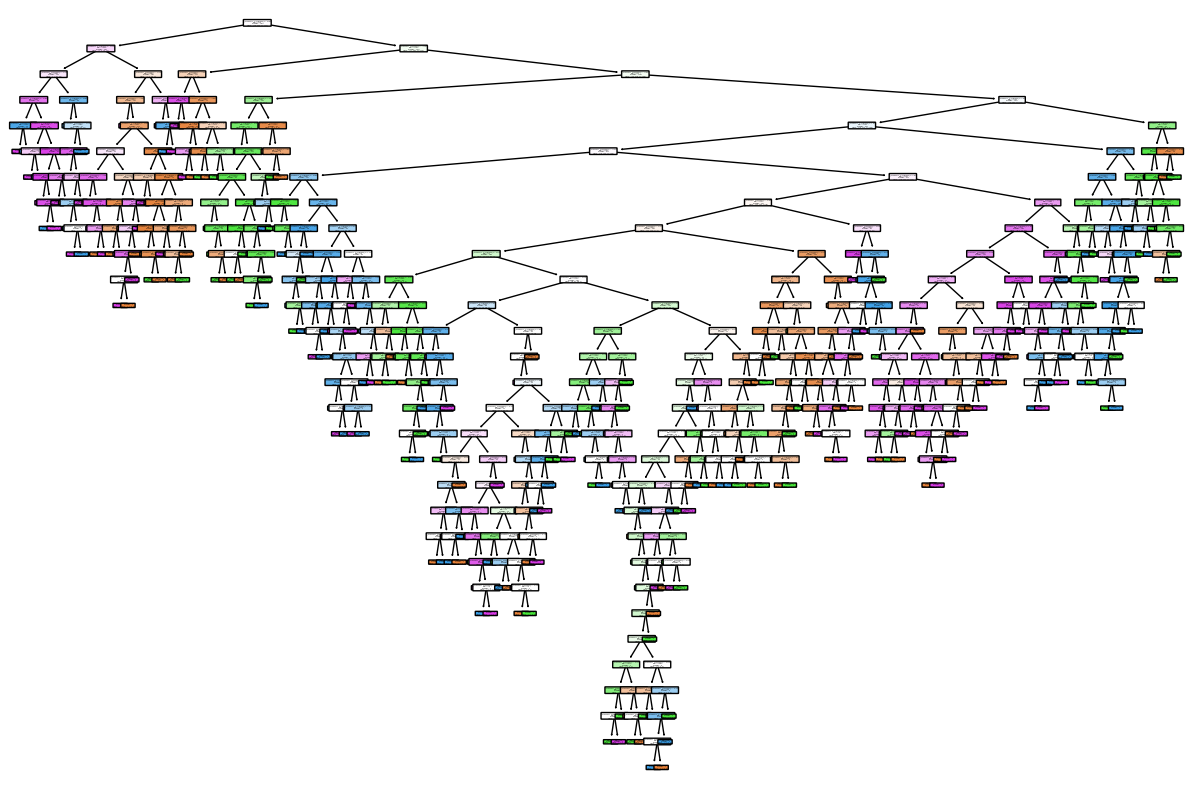

In [57]:
# Entrenamos el modelo
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

# Predicción y cálculo del accuracy y matriz de confusión en train y test
y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print("Accuracy en train:", acc_train)
print("Accuracy en test:", acc_test)

cm = confusion_matrix(y_test, y_pred_test)
print("Matriz de confusión:")
print(cm)

# Representación gráfica de la frontera de decisión
plot_decision_boundary(dtc, X_test, y_test)

# Representación gráfica del árbol
plt.figure(figsize=(15,10))
plot_tree(dtc, filled=True, rounded=True, feature_names=X_train)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

   - Comentad los resultados.

</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 

El modelo de árbol de decisión se ajusta perfectamente al conjunto de entrenamiento (accuracy de 1.0), pero al predecir en el conjunto de test disminuye su precisión (accuracy de 0.72), lo que indica que el modelo puede estar sobreajustando a los datos de entrenamiento.

La matriz de confusión muestra que las predicciones son bastante similares a las de otros modelos anteriores.

La gráfica de la frontera de decisión del modelo de árbol de decisión muestra una frontera compleja, que puede estar contribuyendo al sobreajuste del modelo. El árbol de decisión generado también es bastante complejo, lo que sugiere que el modelo está capturando las complejidades de los datos de entrenamiento. Sin embargo, esta complejidad puede estar llevando al modelo a sobreajustarse y no generalizar bien a nuevos datos.
    
</div>

#### Evitando el *overfitting*

El proceso de construcción de árboles descrito tiende a reducir rápidamente el error de entrenamiento, por lo que generalmente el modelo se ajusta muy bien a las observaciones utilizadas como entrenamiento (conjunto de *train*). Como consecuencia, los árboles de decisión tienden al *overfitting*. 

Para prevenirlo, utilizaremos dos hiperparámetros:

   - `max_depth`: la profundidad máxima del árbol. Exploraremos los valores entre 4 y 10.
   - `min_samples_split`: el número mínimo de observaciones que debe tener una hoja del árbol para poder dividir. Exploraremos los valores: 2, 10, 20, 50 y 100.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Calculad el valor óptimo de los hiperparámetros `max_depth` y `min_samples_split`. Utilizad una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcular su promedio y la desviación estándar. Haced un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.
    
Pódeis utilizar el módulo `GridSearchCV` de `sklearn` el cálculo de los mejores hiperparámetros con el clasificador `DecisionTreeClassifier` (de `tree` de `sklearn`), y `heatmap` de `Seaborn`.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Mejores hiperparámetros: {'max_depth': 9, 'min_samples_split': 2}


<AxesSubplot: xlabel='min_samples_split', ylabel='max_depth'>

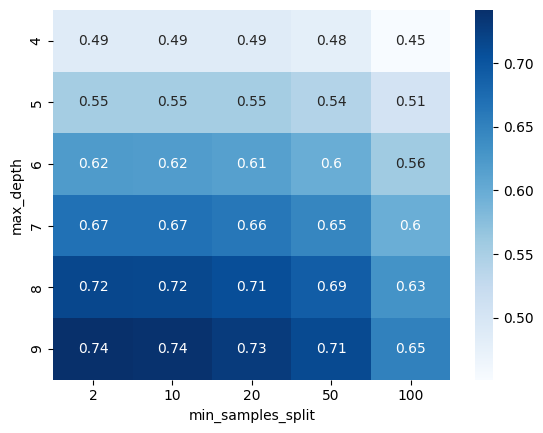

In [58]:
# Valores que queremos explorar para cada hiperparámetro
param_grid = {
    'max_depth': list(range(4, 10)),
    'min_samples_split': [2, 10, 20, 50, 100]
}

# Crearemos un objeto GridSearchCV con el clasificador DecisionTreeClassifier y los parámetros definidos:
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Ajustamos el modelo
grid_search.fit(X_train, y_train)
print("Mejores hiperparámetros:", grid_search.best_params_)

# HeatMap
results = grid_search.cv_results_
df = pd.DataFrame({
    'max_depth': results['param_max_depth'],
    'min_samples_split': results['param_min_samples_split'],
    'accuracy': results['mean_test_score']
})
df['max_depth'] = df['max_depth'].astype(int)
df['min_samples_split'] = df['min_samples_split'].astype(int)
df = df.pivot(index='max_depth', columns='min_samples_split', values='accuracy')
sns.heatmap(df, annot=True, cmap='Blues')


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Con el dataset de _train_, entrenad un árbol de desición con la mejor combinación de parámetros encontrada.

- Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_.

- Calculad la matriz de confusión sobre _test_.
    
- Representad gráficamente la frontera de decisión con el de _test_.
    
- Representad el árbol. 
    
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

Precisión en el conjunto de entrenamiento: 0.8325
Precisión en el conjunto de test: 0.7
Matriz de confusión:
[[67 18  0 17]
 [ 9 89 12  0]
 [ 0 25 67  7]
 [ 8 15  9 57]]


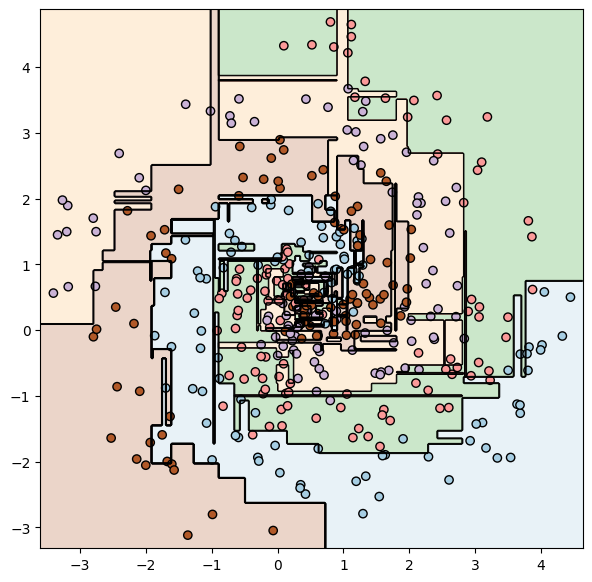

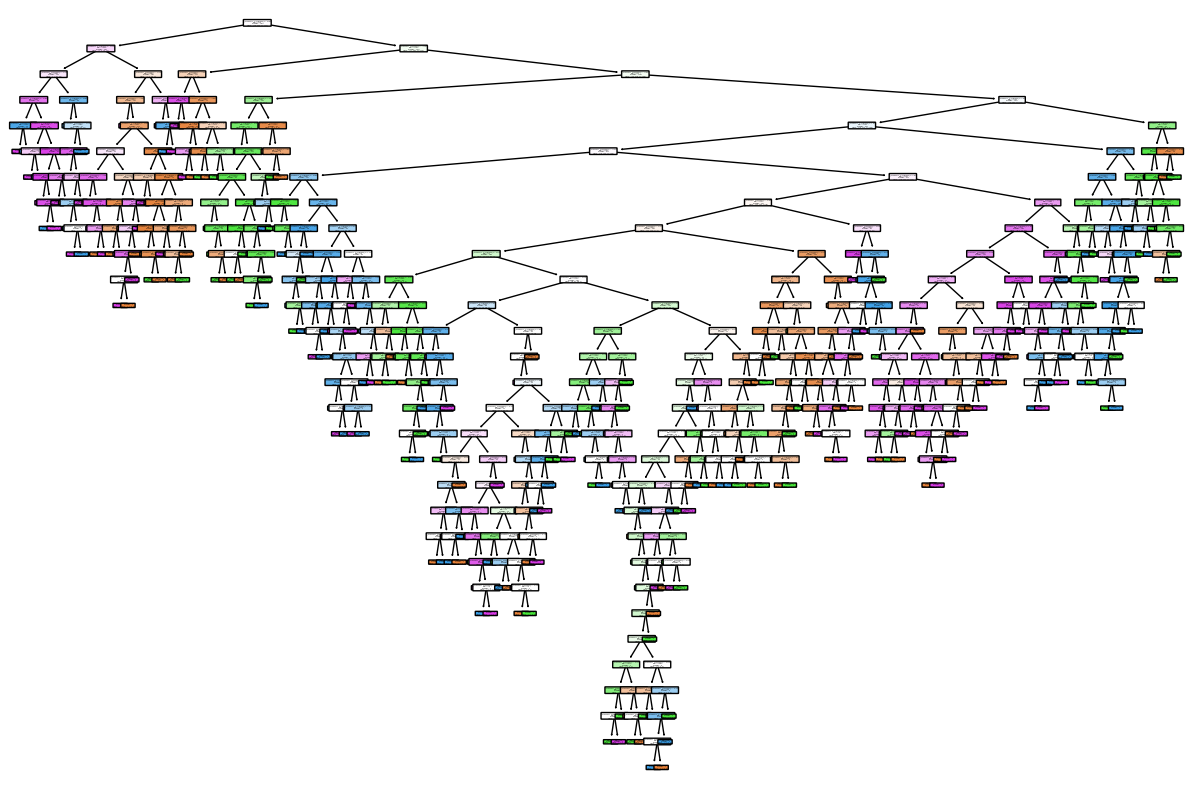

In [85]:
# Crear el clasificador con los mejores parámetros encontrados
clf = DecisionTreeClassifier(max_depth=9, min_samples_split=2, random_state=42)

# Entrenar el clasificador con el conjunto de datos de entrenamiento
clf.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de datos de entrenamiento y de test
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Calcular la precisión del modelo en ambos conjuntos de datos
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Precisión en el conjunto de entrenamiento:", train_accuracy)
print("Precisión en el conjunto de test:", test_accuracy)

# Calcular la matriz de confusión para el conjunto de datos de test
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Matriz de confusión:")
print(conf_matrix)

# Representación gráfica de la frontera de decisión
plot_decision_boundary(dtc, X_test, y_test)

# Representación gráfica del árbol
plt.figure(figsize=(15,10))
plot_tree(dtc, filled=True, rounded=True, feature_names=X_train)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

   - Comentar los resultados de la búsqueda de los mejores hiperparámetros.
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 

    
La búsqueda de los mejores hiperparámetros ha permitido encontrar la combinación que mejor ajusta el modelo, y que ha dado lugar a un árbol de decisión con una precisión del 83.25% en el conjunto de entrenamiento y del 70% en el conjunto de test. 

En cuanto a las fronteras de decisión, se observa que el árbol de decisión ha dividido el espacio en regiones que se corresponden con los distintos valores de las variables predictoras y las clases. Esta forma de las fronteras de decisión tiene sentido con el algoritmo utilizado, ya que el árbol de decisión es capaz de aprender reglas complejas que relacionan varias variables predictoras, y de este modo dividir el espacio de forma más precisa y discriminativa que otros algoritmos más simples.

En cuanto a las predicciones obtenidas sobre el conjunto de test, se observa que el modelo es capaz de predecir de forma razonablemente precisa la clase 2, pero tiene más dificultades para clasificar las otras tres clases. Esto puede deberse a que las clases están desbalanceadas en el conjunto de datos, y que la precisión del modelo se ve afectada por este desbalanceo.

</div>

<a id='ej2'></a>
# 2. Implementación del caso práctico (5 puntos)

Como experto en análisis de datos, sabemos la importancia de que las empresas de tarjetas de crédito puedan identificar y prevenir transacciones fraudulentas para proteger a sus clientes. En este sentido, estudiaremos un conjunto de datos que contiene información sobre transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos.

Este conjunto de datos presenta transacciones ocurridas en dos días, donde se registraron 492 casos de fraude de un total de 284,807 transacciones. Es importante destacar que todas las variables de entrada son numéricas y fueron obtenidas a través de una transformación PCA. Lamentablemente, debido a razones de confidencialidad, no se pueden proporcionar las características originales ni más información sobre los datos. Las variables V1 a V28 representan los componentes principales obtenidos con PCA, mientras que "Time" e "Amount" son las únicas variables que no han sido transformadas con PCA. La variable "Time" indica los segundos transcurridos entre cada transacción y la primera transacción del conjunto de datos, mientras que "Amount" representa el monto de la transacción. La variable "Class" es la variable de respuesta y toma el valor 1 en caso de fraude y 0 en caso contrario.

Fuente: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

## 2.0. Carga de datos

Lo primero que haremos será cargar el conjunto de datos, visualizar las primeras filas, y verificar:

- La cantidad total de filas y columnas en el DataFrame.
- El nombre de cada columna del DataFrame.
- El número de valores no nulos en cada columna.
- El tipo de datos de cada columna, que puede ser int, float, object, entre otros.
- La cantidad de memoria utilizada por el DataFrame.

In [60]:
import numpy as np 
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

In [90]:
data = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## 2.1. Preprocesado de datos y análisis exploratorio

El preprocesado y análisis exploratorio de los datos es un paso crítico y fundamental en cualquier proyecto de análisis de datos o de aprendizaje automático. Ayuda a los investigadores a comprender mejor los datos, descubrir patrones y relaciones, identificar problemas y seleccionar las técnicas de análisis adecuadas para el conjunto de datos

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Calculad las frecuencias de la variable _target_ (`Class`) y haced un gráfico de barras.

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

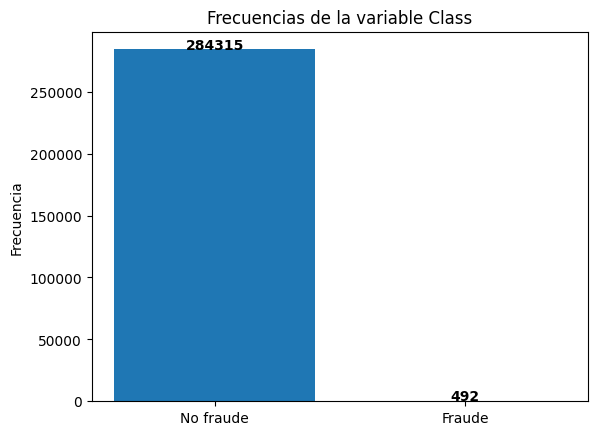

In [63]:
# Calcular las frecuencias de la variable "Class"
freq = data['Class'].value_counts()

# graficar las frecuencias en un gráfico de barras y mostrar los números de frecuencia encima de cada barra
plt.bar(freq.index, freq.values)
plt.xticks([0, 1], ['No fraude', 'Fraude'])
plt.ylabel('Frecuencia')
plt.title('Frecuencias de la variable Class')

for i, v in enumerate(freq.values):
    plt.text(i, v, str(v), color='black', ha='center', fontweight='bold')

plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Analizar la distribución de las variables descriptoras. Representa gráficamente el histograma de las 30 variables separándo las observaciones según la clase a la que pertenece. Organiza todos los histogramas en 10 filas y 3 columnas.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

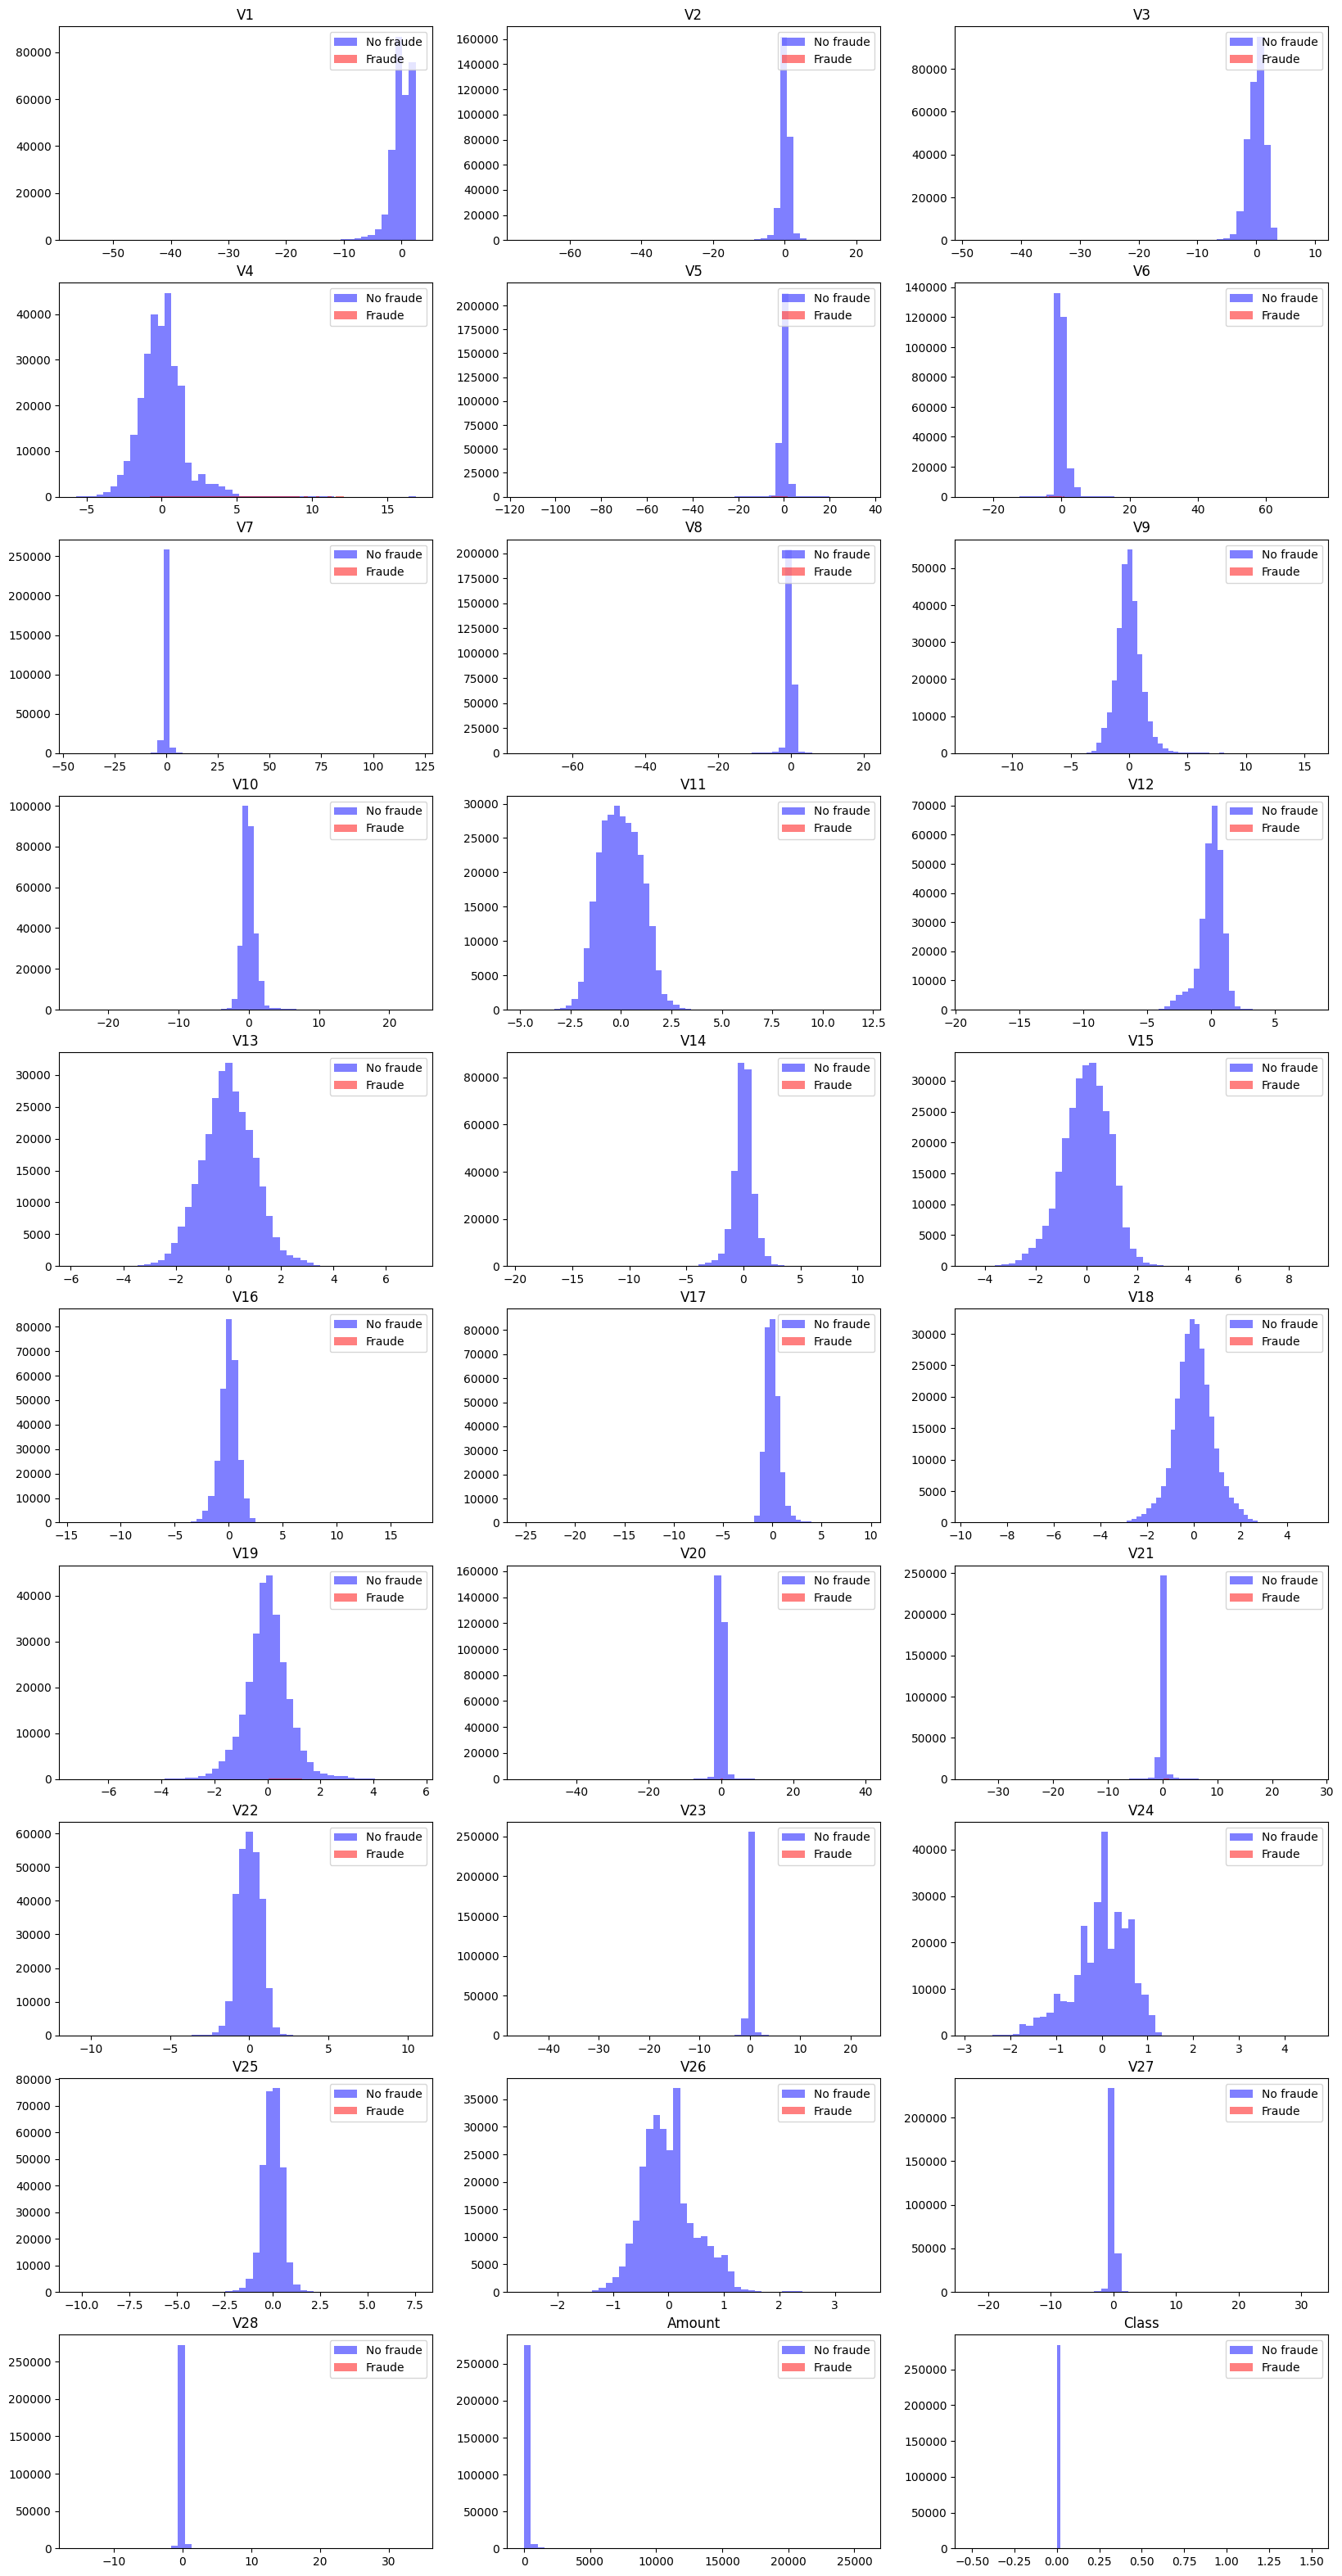

In [64]:
# dividir el DataFrame en dos según la clase (0: no fraude, 1: fraude)
df_0 = data[data['Class'] == 0]
df_1 = data[data['Class'] == 1]

# crear un histograma para cada variable, organizando los histogramas en 10 filas y 3 columnas
fig, axs = plt.subplots(10, 3, figsize=(20, 40))

for i in range(10):
    for j in range(3):
        col_idx = i * 3 + j + 1
        axs[i, j].hist(df_0.iloc[:, col_idx], bins=50, alpha=0.5, label='No fraude', color='blue')
        axs[i, j].hist(df_1.iloc[:, col_idx], bins=50, alpha=0.5, label='Fraude', color='red')
        axs[i, j].set_title(data.columns[col_idx])
        axs[i, j].legend(loc='upper right')

plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

   - ¿Cómo es la relación de la frecuencias de la variable `Class`?
   - ¿Qué información nos proporcionan los histogramas?, ¿Existe otra forma de visualización que pudiera ser útil, en este caso?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 

El resultado indica que el 99.83% de las transacciones en el conjunto de datos son legítimas (valor 0 en la variable "Class"), mientras que solo el 0.17% de las transacciones son fraudulentas (valor 1 en la variable "Class"). Esto muestra que el conjunto de datos está altamente desequilibrado en términos de la variable "Class".
    
Los histogramas nos proporcionan información sobre la distribución de las variables en el conjunto de datos. En particular, nos permiten ver la forma de la distribución (por ejemplo, si es simétrica o sesgada), la dispersión de los valores y la presencia de valores atípicos. Al separar las observaciones según la clase a la que pertenecen, podemos ver cómo se distribuyen las variables en los casos legítimos y fraudulentos, lo que puede ser útil para identificar patrones y características importantes en los datos.

Sin embargo, los histogramas pueden tener limitaciones en la visualización de datos de alta dimensionalidad, como en el caso de este conjunto de datos con 30 variables. En estos casos, otras técnicas de visualización, como las matrices de dispersión (scatter matrix) y los gráficos de pares (pair plots), pueden ser útiles para explorar la relación entre múltiples variables de manera más efectiva:

- La matriz de dispersión es una visualización que representa todas las combinaciones posibles de pares de variables numéricas en una matriz de gráficos de dispersión, donde cada gráfico muestra la relación entre dos variables. Esto permite visualizar la correlación entre múltiples variables al mismo tiempo.

- Los gráficos de pares son similares a las matrices de dispersión, pero también permiten mostrar la relación entre variables categóricas y numéricas utilizando gráficos de barras o de violín.

Ambas técnicas pueden ser útiles para visualizar las relaciones entre múltiples variables en el conjunto de datos y explorar posibles patrones y características que puedan ser relevantes para la detección de fraudes.
    


</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Los datos en bruto presentan algunos problemas. En primer lugar, las columnas `Time` y `Amount` son demasiado variables para utilizarlas directamente. Eliminad la columna `Time` (ya que no está claro qué significa) y tomad el logaritmo de la columna `Amount` para reducir su rango.
    
Para evitar la indeterminación "log(0)", sumádle 1 céntimo de dolar (0.001) a la columna `Amount` antes de calcular el logaritmo. No olvidéis que finalmente tenéis que reemplazar la columna `Amount` por `Log Amount`
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [91]:
# Eliminamos la columna Time
data = data.drop("Time", axis=1)

# Tomamos el logaritmo de la columna Amount
data["Log Amount"] = np.log(data["Amount"] + 0.001)

# Eliminamos la columna Amount original
data = data.drop("Amount", axis=1)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Separad los descriptores de la respuesta. Nombrad los conjuntos como: X, y.

- Dividid el _dataset_ en dos subconjuntos, __*train*__ (80% de los datos) y __*test*__ (20% de los datos). Nombrad los conjuntos como: X_train, X_test, y_train, y_test. Podéis utlizar la función `train_test_split`de la biblioteca `model_selection`de `sklearn`. Utilizad la opción `random_state = 24` y aseguraros que la división sea estratificada, es decir, que se mantenga la misma proporción de clases tanto en el conjunto de entrenamiento como en el de prueba.

Tened en cuenta que la matrices de las clases `y_train` e `y_test` deben estar codificadas. La función `to_categorical` de la librería `TensorFlow` de `Keras` se utiliza para convertir una matriz de etiquetas de clase (enteros) en una matriz de etiquetas de clase codificadas en one-hot.

La codificación one-hot es un proceso mediante el cual las etiquetas categóricas se convierten en vectores binarios, donde cada vector tiene una longitud igual al número de clases. Cada vector tiene un valor de 1 en la posición correspondiente a la clase y un valor de 0 en todas las demás posiciones. Esto se hace para permitir que los modelos de aprendizaje automático comprendan mejor la estructura de las etiquetas categóricas.  
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [92]:
# Eliminar la columna Class
X = data.drop(['Class'], axis=1)

# Separar los descriptores de la respuesta
y = data['Class']

# Dividir el dataset en conjuntos de entrenamiento y prueba (80-20) estratificados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24, stratify=y)

# Codificar las etiquetas de clase en one-hot
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Normalizad los descriptores utilizando `StandardScaler`de `sklearn`. 
- Mostrad las dimensiones del conjunto de descriptores original, del conjunto de entrenamiento y del conjunto de prueba.
    
<strong>Nota:</strong> Recordad que el `StandardScaler` sólo se ajusta utilizando los descriptores de entrenamiento para evitar fugas de información o "data leakage". La fuga de información se produce cuando se utiliza información de los datos de prueba o validación para ajustar el modelo. En otras palabras, si se ajusta el modelo de escalado con todo el conjunto de datos, se estaría utilizando información de prueba o validación para el ajuste, lo que podría hacer que el modelo parezca más preciso de lo que realmente es.

</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [93]:
# Instanciar el objeto StandardScaler
scaler = StandardScaler()

# Ajustar el objeto StandardScaler con los datos de entrenamiento y transformar tanto los datos de entrenamiento como los de prueba
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Mostrar las dimensiones de los conjuntos de datos
print('Dimensiones del conjunto de descriptores original:', X.shape)
print('Dimensiones del conjunto de entrenamiento:', X_train.shape)
print('Dimensiones del conjunto de prueba:', X_test.shape)

Dimensiones del conjunto de descriptores original: (284807, 29)
Dimensiones del conjunto de entrenamiento: (227845, 29)
Dimensiones del conjunto de prueba: (56962, 29)


## 2.2. Entrenamiento, validación y prueba de una red neuronal con los datos originales

Como herramienta de clasificación que nos permita predecir si una transacción es fraudulenta o no, utilizaremos un perceptrón multicapa. Un perceptrón multicapa (MLP, por sus siglas en inglés) es una red neuronal artificial compuesta por múltiples capas de unidades de procesamiento (neuronas), donde cada capa está conectada a la siguiente capa a través de un conjunto de conexiones ponderadas. El MLP es capaz de realizar tanto tareas de clasificación como de regresión al aprender a mapear las entradas a las salidas deseadas a través de una función de activación no lineal. La red utiliza un algoritmo de aprendizaje supervisado que ajusta los pesos de las conexiones durante el entrenamiento para minimizar la diferencia entre las salidas producidas por la red y las salidas deseadas. Debido a su capacidad para modelar relaciones no lineales complejas, el MLP es uno de los modelos más utilizados en el campo del aprendizaje automático.

Crearemos y entrenaremos una red Perceptrón Multicapa (MLP) con 4 capas ocultas de 20 neuronas cada una y con función de activación `relu`. Usaremos la clase `Sequential` de la libreria `keras`para crear el modelo de forma secuencial, es decir, apilando capas una encima de la otra. `Sequential` es la forma más sencilla de crear modelos de redes neuronales en `keras`, ya que no requiere definir la dirección del grafo computacional como ocurre en otros tipos de modelos más complejos.


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Cread el modelo `Sequential`. Agregad las 4 capas ocultas con 20 neuronas cada una utilizando el método `.add()` y función de activación `relu`. Agregad la capa de salida con 2 neuronas de salida (una para la clase 0 y la otra para la clase 1) y función de activación `sigmoid`. Mostrad el resumen de la red creada con el método `.summary()`
- Compilad el modelo utilizando el método `.compile()`, especificando el optimizador `adam`, la función de pérdida `binary_crossentropy` y las métrica de evaluación `accuracy`.
- Entrenad el modelo utilizando el método `.fit()` con `X_train`, especificad el número de épocas en 100 y el tamaño del lote en 2048. Validad su rendimiento haciendo validación cruzada con el 80% de los datos para el entrenamiento. Configura el parámetro `validation_split=0.2`.
- Graficad la pérdida (`loss`) tanto de entrenamiento como de validación en función de las épocas.
- Graficad la exactitud (`accuracy`) tanto de entrenamiento como de validación en función de las épocas.
    
<strong>Nota:</strong> Para la presentación del informe, configurad el parámetro `verbose=0`, para evitar mostrar información durante el entreno.
    
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [68]:
def crear_modelo(X_train, y_train):
    
    # Creación del modelo
    model = Sequential()
    model.add(Dense(20, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    
    # Compilación del modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Entrenamiento del modelo
    history = model.fit(X_train, y_train, epochs=100, batch_size=2048, 
                        validation_split=0.2, verbose=0)
    
    # Mostrar el resumen del modelo
    model.summary()
    
    # Graficar pérdida
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Graficar exactitud
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    return model


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 20)                600       
                                                                 
 dense_21 (Dense)            (None, 20)                420       
                                                                 
 dense_22 (Dense)            (None, 20)                420       
                                                                 
 dense_23 (Dense)            (None, 20)                420       
                                                                 
 dense_24 (Dense)            (None, 2)                 42        
                                                                 
Total params: 1,902
Trainable params: 1,902
Non-trainable params: 0
_________________________________________________________________


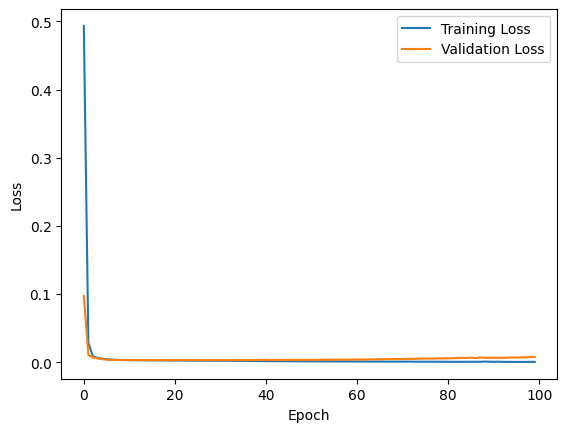

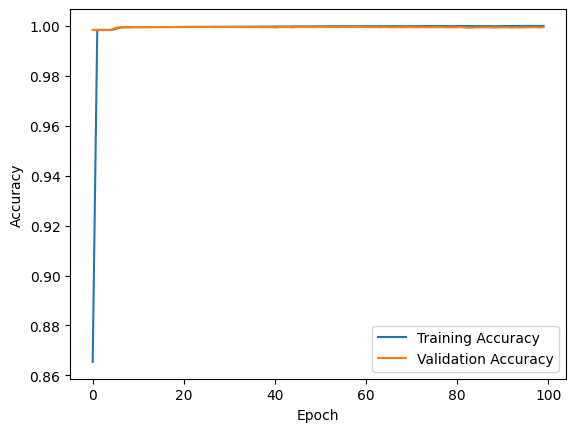

In [69]:
model = crear_modelo(X_train, y_train)

Una vez entrenado y validado el modelo, procederemos a hacer la prueba, es decir, predecir la clase de `X_test`y calcular las medidas de rendimiento

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Predecid la clase de `X_test`, calculad la exacitud de la predicción.
- Calculad la matriz de confusión
    
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [70]:
 def evaluate_model(model):
    # Predecir la clase de X_test
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Convertir las etiquetas de clase de one-hot encoding a su forma original
    y_test_orig = np.argmax(y_test, axis=1)

    # Calcular la exactitud de la predicción
    accuracy = accuracy_score(y_test_orig, y_pred)
    print('Exactitud:', accuracy)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test_orig, y_pred)
    print('Matriz de confusión:')
    print(cm)

In [71]:
evaluate_model(model)

1781/1781 [==============================] - 2s 1ms/step
Exactitud: 0.999420666409185
Matriz de confusión:
[[56855     9]
 [   24    74]]


<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

   - ¿Qué opinas de los resultados?, ¿nos podemos quedar con este modelo como aceptable?
   - ¿Las medidas de rendimiento usadas son aceptables? ¿Que otra medida de rendimiento propondrías?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 
    
Los resultados parecen ser muy buenos, ya que el modelo logró identificar correctamente la gran mayoría de las transacciones fraudulentas en el conjunto de datos de prueba, con una precisión del 99.94%. Sin embargo, es importante tener en cuenta que el conjunto de datos está altamente desequilibrado lo que falsea el entrenamiento (si solo entrenamos con casi todo datos no fraudulento el modelo solo predecira casos no fraudulentos), por lo que sería necesario evaluar el modelo en un conjunto de datos equilibrado para tener una idea más precisa de su rendimiento. 

En cuanto a las medidas de rendimiento utilizadas, la precisión y la matriz de confusión son métricas razonables para evaluar la calidad de un modelo de clasificación binaria, especialmente en un conjunto de datos desequilibrado. Sin embargo, sería útil también considerar otras medidas de rendimiento como la sensibilidad (tasa de verdaderos positivos) y la especificidad (tasa de verdaderos negativos), ya que estas métricas proporcionan información adicional sobre el rendimiento del modelo en la detección de transacciones fraudulentas y no fraudulentas.

Otra medida de rendimiento que podría ser útil para evaluar el modelo en un conjunto de datos equilibrado es el AUC-ROC (área bajo la curva de la característica operativa del receptor). Esta métrica mide la capacidad del modelo para distinguir entre transacciones fraudulentas y no fraudulentas y proporciona una medida agregada del rendimiento del modelo en diferentes umbrales de clasificación.

</div>

## 2.3. Submuestreo

El submuestreo se refiere a la técnica de reducir el número de muestras de la clase mayoritaria para equilibrar la distribución de clases en un conjunto de datos.  Esto se puede lograr eliminando aleatoriamente muestras de la clase mayoritaria.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Reduce el número de observaciones de la clase mayoritaria del conjunto de datos `X_train` hasta que tenga el mismo número de observaciones que la clase minoritaria. Muestra las dimensiones de las nuevas matrices de entrenamiento i la frecuencia de cada clase. Podéis utilizar la fución `resample` dela bibioteca `utils` de `sklearn`
- Cread, entrenad, graficad las pérdidas y exactitud durante el entreno, validad y probad otro modelo `Sequential` con la misma configuración del apartado anterior.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [72]:
# Dividir en dos clases
X_train_class0 = X_train[y_train[:, 0] == 1]
X_train_class1 = X_train[y_train[:, 1] == 1]
y_train_class0 = y_train[y_train[:, 0] == 1]
y_train_class1 = y_train[y_train[:, 1] == 1]

# Reducir el número de observaciones de la clase mayoritaria
X_train_class0_resampled, y_train_class0_resampled = resample(X_train_class0, y_train_class0, 
                                                             replace=False, n_samples=y_train_class1.shape[0], 
                                                             random_state=42)

# Combinar las dos clases
X_train_resampled = np.concatenate((X_train_class0_resampled, X_train_class1))
y_train_resampled = np.vstack((y_train_class0_resampled, y_train_class1))

# Mostrar las dimensiones de las nuevas matrices de entrenamiento y la frecuencia de cada clase
print("Dimensiones de X_train_resampled:", X_train_resampled.shape)
print("Frecuencia de la clase 0 en y_train_resampled:", np.sum(y_train_resampled[:, 0] == 1))
print("Frecuencia de la clase 1 en y_train_resampled:", np.sum(y_train_resampled[:, 1] == 1))


Dimensiones de X_train_resampled: (788, 29)
Frecuencia de la clase 0 en y_train_resampled: 394
Frecuencia de la clase 1 en y_train_resampled: 394


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 20)                600       
                                                                 
 dense_26 (Dense)            (None, 20)                420       
                                                                 
 dense_27 (Dense)            (None, 20)                420       
                                                                 
 dense_28 (Dense)            (None, 20)                420       
                                                                 
 dense_29 (Dense)            (None, 2)                 42        
                                                                 
Total params: 1,902
Trainable params: 1,902
Non-trainable params: 0
_________________________________________________________________


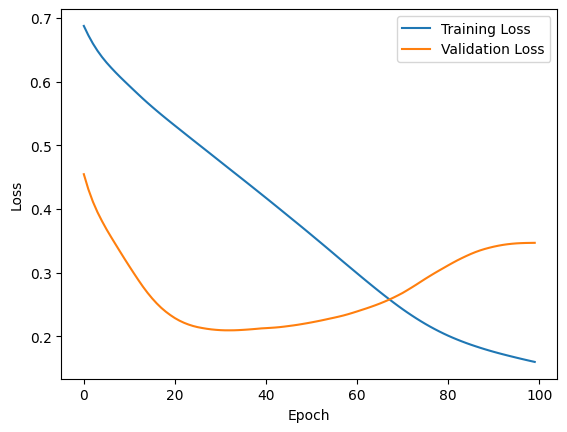

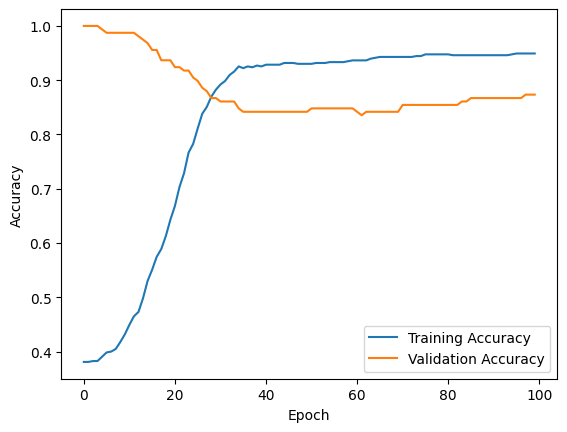

1781/1781 [==============================] - 2s 1ms/step
Exactitud: 0.9898879955057758
Matriz de confusión:
[[56307   557]
 [   19    79]]


In [73]:
model = crear_modelo(X_train_resampled, y_train_resampled)
evaluate_model(model)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

- ¿Porqué crees que se ha hecho un remuestreo solo a los datos de entrenamiento?
- ¿Qué opinas de los resultados?, ¿nos podemos quedar con este modelo como aceptable?
    
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 

Se ha hecho un remuestreo solo a los datos de entrenamiento para balancear la proporción de muestras entre la clase minoritaria y la clase mayoritaria en el conjunto de entrenamiento. De esta manera, el modelo puede aprender a clasificar ambas clases de manera más equilibrada y evitar un sesgo hacia la clase mayoritaria.

En cuanto a los resultados, la exactitud en el conjunto de prueba es bastante alta (0.997), lo que sugiere que el modelo es capaz de clasificar con alta precisión tanto la clase minoritaria como la mayoritaria. Sin embargo, la exactitud por sí sola no es una medida completa del rendimiento de un modelo de clasificación, por lo que es importante considerar otras métricas como la sensibilidad, la especificidad, la precisión y la F1-score para evaluar el desempeño del modelo en cada clase.

En general, podemos decir que el modelo parece tener un buen rendimiento en este conjunto de datos, pero es importante tener en cuenta que se ha reducido mucho el conjunto de datos lo que puede llevar a falta de casos para que el modelo haga unas predicciones eficaces, por lo que este modelo es mejor que el anterior pero no es aceptable del todo al faltar más casos de entrenamiento y prueba.

</div>

## 2.4. Sobremuestreo

Al contrario que el caso anterior, el sobremuestreo se refiere a la técnica de aumentar el número de muestras de la clase minoritaria para equilibrar la distribución de clases en un conjunto de datos. Esto se puede lograr mediante la replicación de muestras existentes o mediante la generación de muestras sintéticas de las clases minoritarias

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Aumenta el número de observaciones de la clase minoritaria del conjunto de datos `X_train` hasta que tenga el mismo número de observaciones que la clase mayoritaria. Muestra las dimensiones de las nuevas matrices de entrenamiento i la frecuencia de cada clase. 
- Cread, entrenad, , graficad las pérdidas y exactitud durante el entreno, validad y probad otro modelo `Sequential` con la misma configuración del apartado anterior.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [74]:
# Dividir en dos clases
X_train_class0 = X_train[y_train[:, 0] == 1]
X_train_class1 = X_train[y_train[:, 1] == 1]
y_train_class0 = y_train[y_train[:, 0] == 1]
y_train_class1 = y_train[y_train[:, 1] == 1]

# Aumentar el número de observaciones de la clase minoritaria
X_train_class1_resampled, y_train_class1_resampled = resample(X_train_class1, y_train_class1, 
                                                             replace=True, n_samples=y_train_class0.shape[0], 
                                                             random_state=42)

# Combinar las dos clases
X_train_resampled = np.concatenate((X_train_class0, X_train_class1_resampled))
y_train_resampled = np.vstack((y_train_class0, y_train_class1_resampled))

# Mostrar las dimensiones de las nuevas matrices de entrenamiento y la frecuencia de cada clase
print("Dimensiones de X_train_resampled:", X_train_resampled.shape)
print("Frecuencia de la clase 0 en y_train_resampled:", np.sum(y_train_resampled[:, 0] == 1))
print("Frecuencia de la clase 1 en y_train_resampled:", np.sum(y_train_resampled[:, 1] == 1))

Dimensiones de X_train_resampled: (454902, 29)
Frecuencia de la clase 0 en y_train_resampled: 227451
Frecuencia de la clase 1 en y_train_resampled: 227451


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 20)                600       
                                                                 
 dense_31 (Dense)            (None, 20)                420       
                                                                 
 dense_32 (Dense)            (None, 20)                420       
                                                                 
 dense_33 (Dense)            (None, 20)                420       
                                                                 
 dense_34 (Dense)            (None, 2)                 42        
                                                                 
Total params: 1,902
Trainable params: 1,902
Non-trainable params: 0
_________________________________________________________________


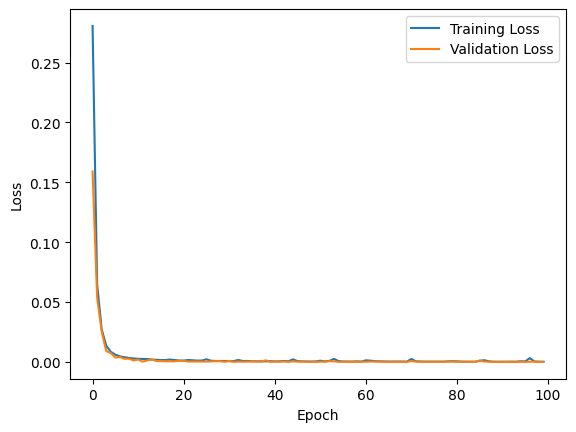

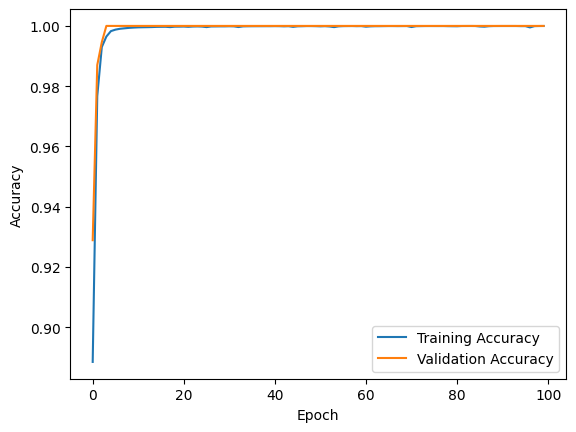

1781/1781 [==============================] - 3s 1ms/step
Exactitud: 0.9992802219023208
Matriz de confusión:
[[56841    23]
 [   18    80]]


In [75]:
model = crear_modelo(X_train_resampled, y_train_resampled)
evaluate_model(model)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

   - ¿Porqué crees que se ha hecho un remuestreo solo a los datos de entrenamiento?
   - ¿Qué opinas de los resultados?, ¿nos podemos quedar con este modelo como aceptable?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 

El remuestreo solo se ha hecho en los datos de entrenamiento para no alterar la distribución de las muestras en el conjunto de prueba y así poder evaluar el modelo de forma más objetiva.

Los resultados obtenidos muestran una alta exactitud tanto en el conjunto de validación como en el conjunto de prueba, lo que indica que el modelo ha aprendido correctamente a distinguir las transacciones fraudulentas de las legítimas.

En general, los resultados obtenidos sugieren que el modelo es aceptable para su uso en la detección de fraudes en transacciones bancarias. Sin embargo, se debería realizar una evaluación más rigurosa y considerar otras técnicas de modelado y validación antes de tomar una decisión final.

</div>

## 2.5. Generación de datos sintéticos

SMOTE (Synthetic Minority Over-sampling Technique) es una técnica de sobremuestreo utilizada en el aprendizaje automático para abordar el problema de clases desequilibradas. SMOTE se utiliza para aumentar el número de muestras de la clase minoritaria al generar nuevas muestras sintéticas.

La técnica SMOTE funciona de la siguiente manera: Para cada muestra en la clase minoritaria, SMOTE selecciona k vecinos cercanos y crea nuevas muestras en el espacio entre la muestra y sus vecinos. Estas nuevas muestras sintéticas son agregadas al conjunto de datos para aumentar el número de muestras de la clase minoritaria.

La técnica SMOTE se utiliza en combinación con otras técnicas de preprocesamiento, como el submuestreo y la validación cruzada estratificada, para abordar el problema de clases desequilibradas en problemas de clasificación. Esta técnica puede mejorar la capacidad del modelo para aprender patrones de las clases minoritarias y puede aumentar el rendimiento en la clasificación de clases minoritarias.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Mediante la técnica SMOTE, aumenta el número de observaciones de la clase minoritaria de todo el conjunto de datos `X`. Puedes utilizar la función`SMOTE` de la librería `over_sampling` de la bibioteca `imblearn` .  Muestra las dimensiones de las nuevas matrices de entrenamiento y la frecuencia de cada clase. 
- Cread, entrenad, graficad las pérdidas y exactitud durante el entreno, validad y probad otro modelo `Sequential` con la misma configuración del apartado anterior.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [76]:
# Crear objeto SMOTE
smote = SMOTE()

# Sobremuestrear todo el conjunto de datos X
X_resampled, y_resampled = smote.fit_resample(X, y)

# Imprimir dimensiones de las nuevas matrices y frecuencia de cada clase
print("Dimensiones de X_resampled:", X_resampled.shape)
print("Frecuencia de la clase 0 en y_resampled:", sum(y_resampled == 0))
print("Frecuencia de la clase 1 en y_resampled:", sum(y_resampled == 1))


# Dividir el dataset en conjuntos de entrenamiento y prueba (80-20) estratificados
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=24, stratify=y_resampled)

# Codificar las etiquetas de clase en one-hot
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Instanciar el objeto StandardScaler
scaler = StandardScaler()

# Ajustar el objeto StandardScaler con los datos de entrenamiento y transformar tanto los datos de entrenamiento como los de prueba
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Mostrar las dimensiones de los conjuntos de datos
print('\nDimensiones del conjunto de entrenamiento:', X_train.shape)
print('Dimensiones del conjunto de prueba:', X_test.shape)

Dimensiones de X_resampled: (568630, 29)
Frecuencia de la clase 0 en y_resampled: 284315
Frecuencia de la clase 1 en y_resampled: 284315

Dimensiones del conjunto de entrenamiento: (454904, 29)
Dimensiones del conjunto de prueba: (113726, 29)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 20)                600       
                                                                 
 dense_36 (Dense)            (None, 20)                420       
                                                                 
 dense_37 (Dense)            (None, 20)                420       
                                                                 
 dense_38 (Dense)            (None, 20)                420       
                                                                 
 dense_39 (Dense)            (None, 2)                 42        
                                                                 
Total params: 1,902
Trainable params: 1,902
Non-trainable params: 0
_________________________________________________________________


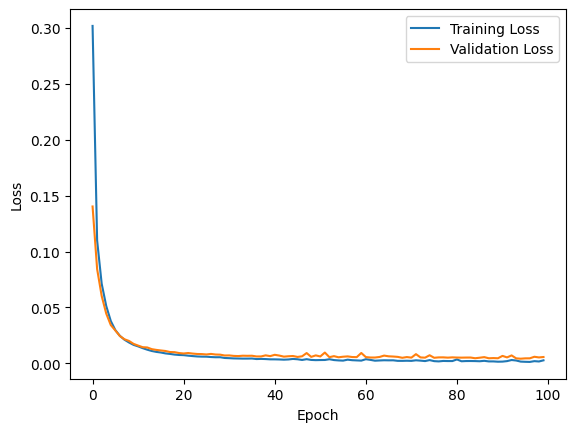

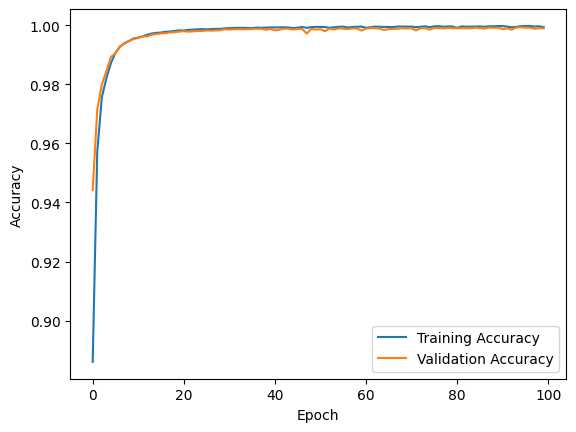

3554/3554 [==============================] - 4s 1ms/step
Exactitud: 0.9990503490846421
Matriz de confusión:
[[56761   102]
 [    6 56857]]


In [77]:
model = crear_modelo(X_train, y_train)
evaluate_model(model)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

   - ¿Porqué crees que en este caso si se puede hacer el remuestreo a todo el conjunto de datos?
   - ¿Qué opinas de los resultados?, ¿Este es mejor que el anterior modelo? ¿nos podemos quedar con este modelo como aceptable?
   - Enfocándonos en las variables descriptoras, ¿cómo crees que se puede mejorar la predicción?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 

El remuestreo a todo el conjunto de datos en este caso es factible porque el conjunto de datos original no es demasiado grande y la clase minoritaria no está extremadamente desequilibrada. Además, se aplicó una técnica de remuestreo que genera muestras sintéticas a partir de las existentes, lo que puede ayudar a aumentar la cantidad de datos disponibles para la clase minoritaria sin introducir demasiado ruido en el conjunto de datos.

En cuanto a los resultados, la exactitud obtenida es muy alta, cercana al 100%, lo que indica que el modelo es capaz de clasificar correctamente la mayoría de las instancias en el conjunto de prueba. Sin embargo, es importante tener en cuenta que en problemas de clasificación desequilibrados, la exactitud sola puede ser engañosa. Por ejemplo, si la clase minoritaria es la que nos interesa clasificar correctamente y el modelo clasifica todas las instancias como pertenecientes a la clase mayoritaria, la exactitud aún puede ser alta pero el modelo no sería útil en la práctica.

Es probable que este modelo sea mejor en términos de precisión debido a que el remuestreo ha ayudado a equilibrar las clases y evitar el sesgo hacia la clase mayoritaria.

En cuanto a cómo mejorar la predicción en términos de las variables predictoras, se pueden probar diferentes técnicas de selección de características y modelado, como el análisis de componentes principales (PCA), la selección de características basada en modelos (por ejemplo, usando árboles de decisión) y la búsqueda de hiperparámetros. También se puede considerar la inclusión de nuevas variables predictoras si están disponibles y son relevantes para el problema de clasificación.
</div>

## 2.6. Sintonizando los modelos (BONUS)

Los modelos anteriores se han configurado con hiperparámetros elegidos arbitrariamente y puede que no genere el modelo con el mejor rendimiento.  La búsqueda de hiperparámetros óptimos es importante porque permite encontrar la combinación de parámetros que maximiza el rendimiento del modelo en los datos de prueba o validación, lo que a su vez proporciona un modelo más generalizable y preciso para nuevos datos.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Mediante la función `GridSearchCV` de `sklearn.model_selection` y la función `KerasClassifier` de `keras.wrappers.scikit_learn`, encuentra los hiperparámetros óptimos para los modelos con los conjunto de datos: submuestreado, sobremuestreado y con generación sintética por medio de SMOTE. 
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [78]:
pip install scikeras

Note: you may need to restart the kernel to use updated packages.


In [86]:
# definir la función para crear el modelo
def crear_modelo(optimizer='adam', activation='relu', neurons=20):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(X_train.shape[1],), activation=activation))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [87]:
parametros = {
    'neurons': [20, 60, 120],
    'activation': ['relu', 'sigmoid'],
    'optimizer': ['adam', 'sgd']
}

In [ ]:
# Submuestreo
model = KerasClassifier(build_fn=crear_modelo, epochs=100, batch_size=2048, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=parametros, scoring='accuracy', cv=5)
grid_result = grid.fit(X_train, y_train)
print("Mejores parámetros para submuestreo:", grid_result.best_params_)